In [61]:
# Import packages
import xarray as xr
import numpy as np
import pandas as pd
import packaging
import matplotlib.pyplot as plt
import netCDF4
import math
import datetime

# Define functions
def read_netcdf4(filename):
    '''Read in data from netcdf4'''
    # read in netcdf4 data to xarray
    storms_data = xr.open_dataset(filename)
    
    return storms_data

def tidy_netcdf4(storms_data, city):
    '''Convert to dataframe, assign headers, set datatypes, perform unit conversions if necessary'''
    
    # tidy data
    storms_data = storms_data['RAINRATE'].sel(location = city).to_dataframe()
    
    # make datetime its own column, not the index
    storms_data['datetime'] = storms_data.index
    storms_data = storms_data.reset_index(drop = True)
    storms_data['datetime'] = pd.to_datetime(storms_data['datetime'])
    storms_data = storms_data.rename(columns = {"RAINRATE": "pr"})
    
    # reorder columns for clarity
    storms_data = storms_data.iloc[:,[2, 0, 1]]
    
    # perform unit conversions if necessary
    # default units for netcdf4 are mm to 0.1 mm accuracy
    
    return storms_data

def read_csv(city):
    '''Read in data from csv, assign headers, set datatypes, perform unit conversions if necessary, and find time step for
       the dataset in minutes.'''
    # read data from csv
    storms_obs = pd.read_csv(f"files/NOAA_15_min/{city}.csv", skiprows = 0, parse_dates = ['DATE'])

    # drop unneccessary and rename cols
    storms_obs = storms_obs.loc[:, ['DATE', 'QPCP']]
    storms_obs = storms_obs.rename(columns = {'DATE' : 'datetime', 'QPCP' : 'pr'})
    
    # QC data - remove NA and NULL values
    # print(storms_obs.loc[:, 'pr'].min(), storms_obs.loc[:, 'pr'].max())
    # remove any negative vals
    storms_obs.loc[storms_obs.pr < 0, 'pr'] = 0
    # remove any exceptionally large vals - > 500 chosen arbitrarily
    storms_obs.loc[storms_obs.pr > 500, 'pr'] = 0
    # print(storms_obs.loc[:, 'pr'].min(), storms_obs.loc[:, 'pr'].max())
    
    return storms_obs

def find_timestep(storms_data):
    '''Find time step of dataset in minutes by subtracting two datetimes'''
    # determine time step by subtracting one datetime from another
    TS = storms_data.iloc[1, 0] - storms_data.iloc[0, 0]
    
    # convert timedelta type to int type in minutes
    TS = TS.total_seconds() / 60
    return TS

def project_by_intensity(storms_modeled_past, storms_modeled_future, storms_obs, TS, subset):
    '''This is the meat of the process. It accepts model and historical data, finds Gumbel shape factors from each dataset, uses them to find
    the CDF value that corresponds with each precipitation intensity, calculates delta factors, and returns a time series of historical
    precipitation that has been projected into the future.'''
    
    # !! resampling actually doesn't work with this data because its TS are non-adjacent temporally
    # !! for now, get hourly values by multiplying 15-min by 4
    # ==========================================================================================================================
    # # resample observed dataset to find hourly sums. This aligns the volumes from the hourly model data and the observed data
    # resample = storms_obs.resample('60min', on = 'datetime').sum()
    # # adjust index to include same number of entries as storms_obs
    # resample = resample.loc[resample.index.repeat(60 / TS)].reset_index()
    # # add resampled data to storms_obs
    # storms_obs['pr_hourly'] = resample.pr
    # ==========================================================================================================================
    
    # !! here's that temp fix for resampling
    storms_obs.loc[:, 'pr_hourly'] = storms_obs.loc[:, 'pr'] * 4
    
    # remove all dry times from datasets - this way only rainy periods are used to characterize the precipitation
    storms_modeled_past_no_0 = storms_modeled_past[storms_modeled_past['pr'] != 0]
    storms_modeled_future_no_0 = storms_modeled_future[storms_modeled_future['pr'] != 0]
    storms_obs_no_0 = storms_obs[storms_obs['pr_hourly'] != 0]    
    
    # calculate statistics for each storm duration based on full rolling input of ~past~ data and find shape factors
    past_mean_pr = storms_modeled_past_no_0['pr'].mean()
    past_std_pr  = storms_modeled_past_no_0['pr'].std()
    euler_mascheroni_constant = 0.577215
    past_beta = past_std_pr * math.sqrt(6) / math.pi
    past_mu = past_mean_pr - past_beta * euler_mascheroni_constant

    # calculate statistics for each storm duration based on full rolling input of ~future~ data and find shape factors
    future_mean_pr = storms_modeled_future_no_0['pr'].mean()
    future_std_pr  = storms_modeled_future_no_0['pr'].std()
    future_beta = future_std_pr * math.sqrt(6) / math.pi
    future_mu = future_mean_pr - future_beta * euler_mascheroni_constant
        
    # calculate statistics for each storm duration based on full rolling input of ~observed~ data and find shape factors
    obs_mean_pr = storms_obs_no_0['pr_hourly'].mean()
    obs_std_pr  = storms_obs_no_0['pr_hourly'].std()
    obs_beta = obs_std_pr * math.sqrt(6) / math.pi
    obs_mu = obs_mean_pr - obs_beta * euler_mascheroni_constant
    
    
    # find the associated CDF value for each precipitation time step, solve for delta factors, and project the observed values into the future
    subset.loc[:, 'obs_CDF']      = np.exp(-1 * np.exp(-1 * (subset.loc[:, 'pr'] - obs_mu) / obs_beta))
    subset.loc[:, 'past_CDF']     = np.exp(-1 * np.exp(-1 * (subset.loc[:, 'pr'] - past_mu) / past_beta))
    subset.loc[:, 'future_CDF']   = np.exp(-1 * np.exp(-1 * (subset.loc[:, 'pr'] - future_mu) / future_beta))
    subset.loc[:, 'past_pr']      = -1 * past_beta *   (np.log(-1 * np.log(subset.loc[:, 'obs_CDF']))) + past_mu
    subset.loc[:, 'future_pr']    = -1 * future_beta * (np.log(-1 * np.log(subset.loc[:, 'obs_CDF']))) + future_mu
    subset.loc[:, 'delta']        = subset.loc[:, 'future_pr'] / subset.loc[:, 'past_pr']
    subset.loc[:, 'projected_pr'] = subset.loc[:, 'delta'] * subset.loc[:, 'pr']

    
    # Add switch to fix edge case where model CDFs are negative for the smallest precipitation values
    # this is caused by the model under predicting precipitation for the study year
    subset.loc[subset.past_pr < 0, 'delta'] = 1
    subset.loc[subset.future_pr < 0, 'delta'] = 1
    subset.loc[subset.delta == 1, 'projected_pr'] = subset.pr

    return subset

In [84]:
# Read netCDF4 data - climate model results for historical and pseudo global warming runs
CONUS_modeled_past   = read_netcdf4('files/CONUS/CONUS404-Historical-50largestcities.nc')
CONUS_modeled_future = read_netcdf4('files/CONUS/CONUS404-PGW-50largestcities.nc')

CONUS_city_list = CONUS_modeled_past['location'].values.tolist()

# here is where loop should begin
# select one city to study
# city = 'San_Francisco'

for city in CONUS_city_list:
    # isolate data for that city from big NETCDF4 files
    storms_modeled_past =   tidy_netcdf4(CONUS_modeled_past, city)
    storms_modeled_future = tidy_netcdf4(CONUS_modeled_future, city)

    # read historical data for that city from csv 
    # Note: data format YYYY/MM/DD HH:MM (local time)
    # Note: Precip (QPCP) is measured in tenths of mm
    storms_obs = read_csv(city)

    # Convert precip depth to mm from tenths of mm
    storms_obs.loc[:, 'pr'] = storms_obs.loc[:, 'pr'] / 10

    # check time step of observed data (CONUS TS is assumed to be known at 1 hr)
    # TS = find_timestep(storms_obs)
    # !! for this, because of bad data (nonconsecutive measurements), going to hardcode a 15-min TS !!
    TS = 15

    # Read 1-year-long TS measured in 5 mins at Dover - just for trying
    # This doesn't really work because it's 5-min data, not 15. Maybe I'll resample
    # I didn't resample, but I did multiply all precip by 3 to quickly go from 5-min to 15-min
    def read_2012_csv(filename):
        '''Read in data from csv, assign headers, set datatypes, perform unit conversions if necessary, and find time step for
        the dataset in minutes.'''
    # read data from csv
        headers = ['datetime', 'pr']
        dtypes = {'col1': 'str', 'col2': 'float'}
        date_cols = ['datetime']
        storms_data = pd.read_csv(filename, dtype = dtypes, header=None, names = headers, skiprows = [0, 1], parse_dates = date_cols)
            
        return storms_data

    data_dover_2012 = read_2012_csv('files/2012_historical.csv')
        # storms_obs.loc[:, 'pr_hourly'] = storms_obs.loc[:, 'pr'] * 4

    # I don't think this makes much of a difference in the results. I'd have to check though.
    data_dover_2012.loc[:, 'pr'] = data_dover_2012.loc[:, 'pr'] * 3

    # Project time series and save results
    projected_by_intensity = project_by_intensity(storms_modeled_past, storms_modeled_future, storms_obs, TS, data_dover_2012)
    project_by_intensity.to_csv(f'files/output/dataframes/{city}.csv', index = False)
    
    # create some plots here and save them to file

c:\Users\akk34\miniforge3\envs\IDF\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\akk34\miniforge3\envs\IDF\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\akk34\miniforge3\envs\IDF\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\akk34\miniforge3\envs\IDF\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\akk34\miniforge3\envs\IDF\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\akk34\miniforge3\envs\IDF\Lib\site-packages\pandas\core\array

<function matplotlib.pyplot.show(close=None, block=None)>

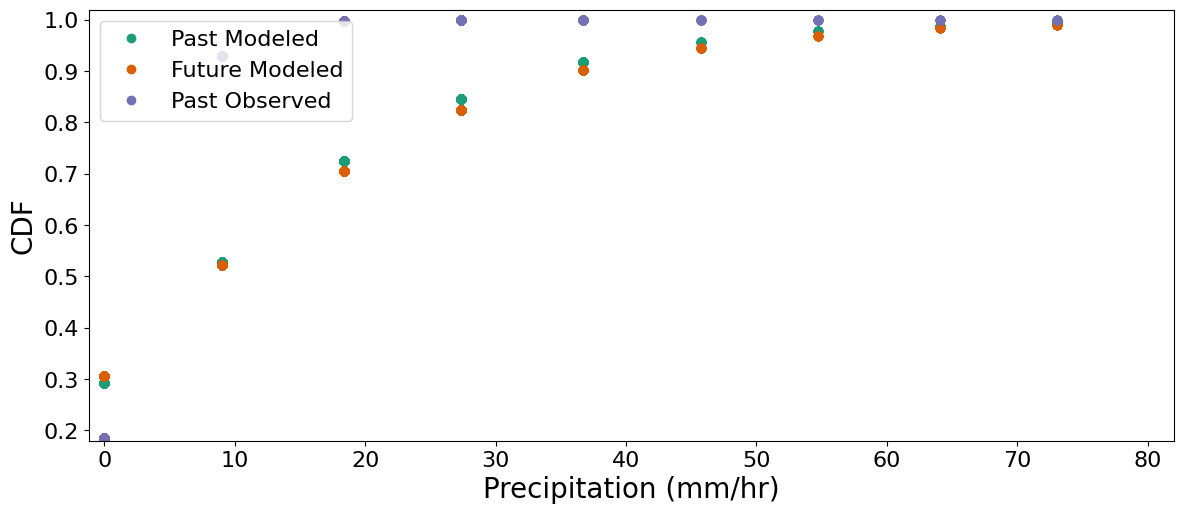

In [69]:
# Establish colors to be used for plots
color0 = ('#1b9e77') # Past modeled
color1 = ('#d95f02') # Future modeled
color2 = ('#7570b3') # Past observed
color3 = ('#E7298A') # Future projected

# Set font size for plots
plt.rcParams.update({'font.size': 16})

# Plot CDF values based on past & future modeled data and observed data
plt.figure(figsize=(14, 5.6))

x1 = projected_by_intensity.pr[:] * 12
y1 = projected_by_intensity.obs_CDF[:]

x2 = x1
y2 = projected_by_intensity.past_CDF[:]

x3 = x1
y3 = projected_by_intensity.future_CDF[:]

# plt.xticks([])    
plt.xlim([-1.2, 82])
plt.ylim([0.18, 1.02])
plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
plt.ylabel("CDF", fontsize = 20)

# print(colors[0])
plt.plot(x2, y2, color = color0, marker='o', linestyle='', label='Past Modeled')
plt.plot(x3, y3, color = color1, marker='o', linestyle='', label='Future Modeled')
plt.plot(x1, y1, color = color2, marker='o', linestyle='', label='Past Observed')
plt.legend(['Past Modeled', 'Future Modeled', 'Past Observed'], loc = 'upper left')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

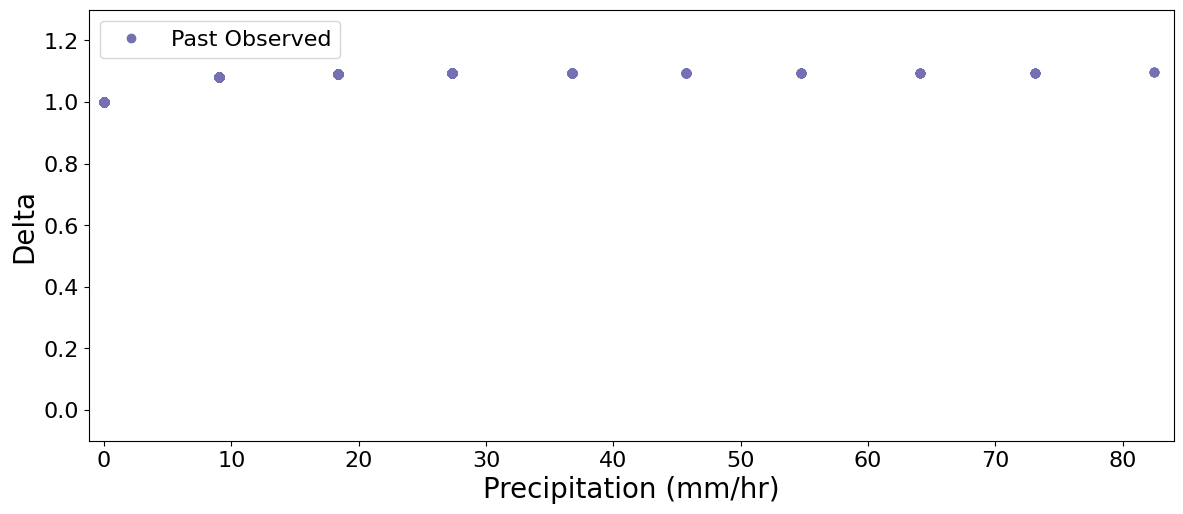

In [70]:
# Plot delta values for each precipitation intensity
plt.figure(figsize=(14, 5.6))

x1 = projected_by_intensity.pr[:] * 12
y1 = projected_by_intensity.delta[:]

plt.xlim([-1.2, 84])
plt.ylim([-0.1, 1.3])
plt.xlabel("Precipitation (mm/hr)", fontsize = 20)
plt.ylabel("Delta", fontsize = 20)

plt.plot(x1, y1, color = color2, marker='o', linestyle='', label='Past Observed')
plt.legend(['Past Observed'], loc = 'upper left')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

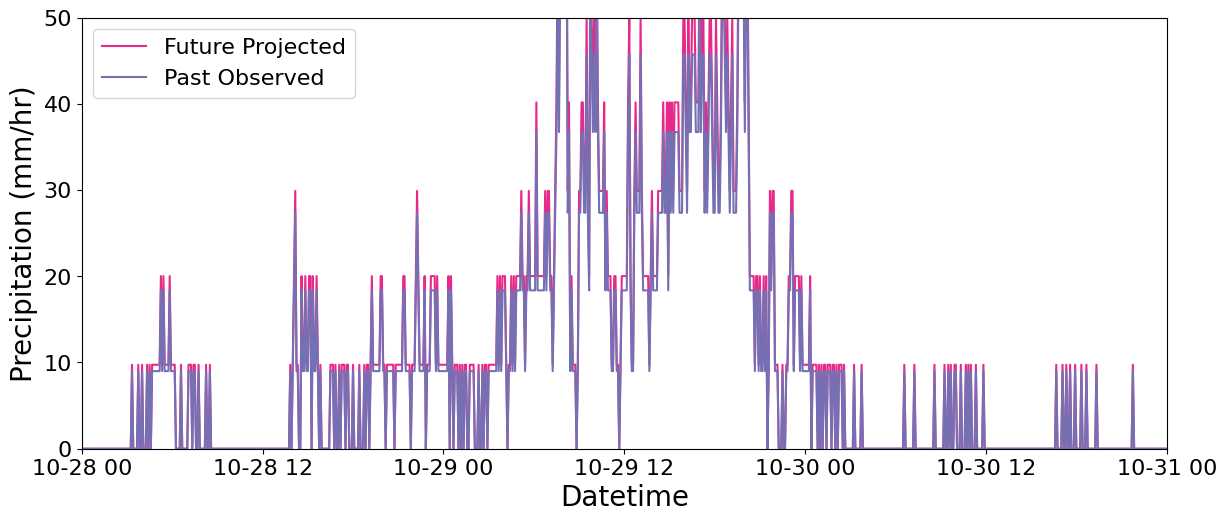

In [71]:
# Plot observed time series vs future projected time series
plt.figure(figsize=(14, 5.6))

x1 = projected_by_intensity.datetime[:]
y1 = projected_by_intensity.pr[:] * 12

x2 = x1
y2 = projected_by_intensity.projected_pr[:] * 12

plt.ylabel("Precipitation (mm/hr)", fontsize = 20)
plt.xlabel("Datetime", fontsize = 20)
plt.xlim([datetime.date(2012, 10, 28), datetime.date(2012, 10, 31)])
plt.ylim([0, 50])

plt.plot(x2, y2, color = color3, label='Future Projected')
plt.plot(x1, y1, color = color2, label='Past Observed')

plt.legend(['Future Projected', 'Past Observed'], loc = 'upper left')

plt.show